### Cab-Driver Agent

In [1]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle
import time

# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver

#### Defining Time Matrix

In [2]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

#### Tracking the state-action pairs for checking convergence


In [3]:
States_track = collections.defaultdict(dict)

In [4]:
# Initialise states to be tracked
def initialise_tracking_states():
  # define the states, which will be tracked
    tracked_state_actions = ["State [4,23,6] Action[4,3]","State [0, 15, 0] Action[1, 0]","State [2, 15, 0] Action[2, 4]","State [2, 15, 0] Action[1, 4]"]
    # Initialize the states with empty list of Q values
    for val in tracked_state_actions:
        States_track[val]=[] 

In [5]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [6]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor = 0.90
        self.learning_rate = 0.01       
        self.epsilon_max = 1.0
        self.epsilon = 1 # Will update the value of epsilon after every episode
        self.epsilon_decay = -0.0009
        self.epsilon_min = 0.001
        
        self.batch_size = 32        
        # create replay memory using deque
        self.memory = deque(maxlen=2000)

        # create main model and target model
        self.model = self.build_model()

    # approximate Q function using Neural Network
    def build_model(self):
        model = Sequential()
        
        # Write your code here: Add layers to your neural nets
        model.add(Dense(32,input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
        
        model.add(Dense(self.action_size, activation='relu', kernel_initializer='he_uniform'))
        
        model.compile(loss='mse',optimizer=Adam(lr=self.learning_rate))
#         model.summary
        return model



    def get_action(self, state):
        # Write your code here:
        # get action from model using epsilon-greedy policy
        # Decay in ε after we generate each sample from the environment       
        
        # We decay the value of epsilon after every episode
        cd = CabDriver()
        
        
        possible_actions_index,actions = cd.requests(state)
        
        if np.random.random() <= self.epsilon:
            
            return random.choice(actions)
        else:
            # Take the action with highest Q-value
            # First, encode the state and convert to to size (1,36)
            encodeState = np.array(cd.state_encod_arch1(state)).reshape(1,36)
#             encodeState = cd.state_encod_arch1(state)
            #Now, we would predict the Q-values
            q_values = self.model.predict(encodeState)
            #We only want the Q values, which are relevant for the actions for the state
            q_values_relevant = [q_values[0][i] for i in possible_actions_index]
            # Return the action with maximum Q value:
            #return possible_actions_index[np.argmax(q_values_relevant)],actions[np.argmax(q_values_relevant)]  
#             print("<<<<Inside get_action>>>>")
#             print("Index of action in action space, having highest Q value: ",possible_actions_index[np.argmax(q_values_relevant)])
#             print("Max Q value: ",q_values_relevant[np.argmax(q_values_relevant)])
#             print("Action returned from get_action: ",actions[np.argmax(q_values_relevant)])
            return actions[np.argmax(q_values_relevant)]     
        


    def append_sample(self, state, action, reward, next_state, done):
        # Write your code here:
        # save sample <s,a,r,s'> to the replay memory
        self.memory.append((state, action, reward, next_state,done))
    
    
    
    
    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
#         print("<<<<Inside train_model>>>>")
        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            update_output = np.zeros((self.batch_size, self.state_size))
            update_input = np.zeros((self.batch_size, self.state_size))
            
            actions, rewards, done = [], [], []
            
            for i in range(self.batch_size):
                state, action, reward, next_state, done_status = mini_batch[i]
                # To predict the Q-values of the current state, convert the current state into encoded vector for input
                update_input[i] = env.state_encod_arch1(state)
                # To predict the Q-values of the next state, convert the next state into encoded vector for input
                update_output[i]= env.state_encod_arch1(next_state)
                actions.append(action)
                rewards.append(reward)
                done.append(done_status)
                
              
            # Write your code from here
            # 1. Predict the target from earlier model
            target = self.model.predict(update_input)
#             print("target looks like: ",target)
            # 2. Get the target for the Q-network
            target_val  = self.model.predict(update_output)
            
            
            #3. Update your 'update_output' and 'update_input' batch
            for i in range(self.batch_size):
                # If the state is not terminal, there is always the next state
                if not done[i]:
#                     print("actions[i]: ",actions[i])
#                     print("target[i]: ",target[i])
#                     print("Index: ",env.action_space.index(actions[i]))
#                     print("Q-Value: ",target[i][env.action_space.index(actions[i])])
                    
                    target[i][env.action_space.index(actions[i])]= rewards[i]+self.discount_factor * (np.amax(target_val[i]))
            # If the state is terminal, there is no next state and the immediate reward is the total reward from that state    
                else:
                    target[i][env.action_space.index(actions[i])]= rewards[i]

                
                
            # 4. Fit your model and track the loss values
            self.model.fit(update_input, target, batch_size=self.batch_size,
                           epochs=1, verbose=0)


    def save(self, name):
        self.model.save(name)
        
    def save_tracking_states(self):
        """
        We are tracking the Q Values for 4 states
        """
        # predict Q value for state [4,23,6]
        q_val_state1 = self.model.predict(np.array(env.state_encod_arch1([4,23,6])).reshape(1,36))
#         print(q_val_state1)
#         print("Type: ",type(q_val_state1))
        # The index for action [4,3] taken from the state is 20. So, 20th element in the q_val_state1 denotes the q value for the action
        States_track["State [4,23,6] Action[4,3]"].append(q_val_state1[0][20])
        
        # predict Q value for state [0, 15, 0]
        q_val_state2 = self.model.predict(np.array(env.state_encod_arch1([0, 15, 0])).reshape(1,36))
        # The index for action [1, 0] taken from the state is 5.
        States_track["State [0, 15, 0] Action[1, 0]"].append(q_val_state1[0][5])
        
        # predict Q value for state [2, 15, 0]
        q_val_state3 = self.model.predict(np.array(env.state_encod_arch1([2, 15, 0])).reshape(1,36))
        # The index for action [2, 4] taken from the state is 12.
        States_track["State [2, 15, 0] Action[2, 4]"].append(q_val_state1[0][12])
                                                                 
        # predict Q value for state [2, 15, 0]                                                         
        q_val_state4 = self.model.predict(np.array(env.state_encod_arch1([2, 15, 0])).reshape(1,36))
        # The index for action [1, 4] taken from the state is 8.
        States_track["State [2, 15, 0] Action[1, 4]"].append(q_val_state1[0][8])

In [7]:
Episodes = 10000

### DQN block

In [8]:
env = CabDriver()
# Call all the initialised variables of the environment
episode_length = 720 # That's because one episode lasts one month which is 24 * 30 = 720 hours
m=5 # 5 locations
t=24 # 24 hours of the day
d=7 # 7 days of the week

# Set the state size
state_size = m+t+d # (5+24+7=36)
# Get the action size
action_size = len(env.action_space)

#Call the DQN agent
agent = DQNAgent(state_size,action_size)


total_episode_rewards = []
start_time = time.time()
initialise_tracking_states()
for episode in range(Episodes):

    # Write code here
    # Call the environment
    action_space, state_space, state = env.reset()
    
    total_reward=0
    
    terminal_state = False
    total_time = 0
#     ride_number = 0
    
    while not terminal_state:
        
        
        action = agent.get_action(state)
        # Write your code here
        # 1. Pick epsilon-greedy action from possible actions for the current state
        # 2. Evaluate your reward and next state
        next_state, reward, total_ride_time = env.take_step(state,action,Time_matrix)
        total_time += total_ride_time
#         ride_number+=1
#         print("Ride number: ", ride_number)
#         print("Present state: ",state)
#         print("Action taken:", action)
#         print("Time taken for the ride: ",total_ride_time)
#         print("Next state: ",next_state)
#         print("Total time so far: ",total_time)
        
        
        # if the total time has exceeded 720 hour, terminiate the episode and break
        if(total_time >= episode_length):
            terminal_state= True
            # We can't leave the driver without a reward, if the last ride goes beyond stipulated 720 hours
            agent.append_sample(state,action,reward,next_state,terminal_state)
            # Train the model
            agent.train_model()
        else:
            # Append the experience to the memory
            agent.append_sample(state,action,reward,next_state,terminal_state)
            # Train the model
            agent.train_model()
#             print("Reward for the ride: ",reward)
            total_reward += reward
#             print("Total reward so far: ",total_reward)
#             print("---------------------------------")
            state = next_state
            
    
    total_episode_rewards.append(total_reward)
    # Save the values of states after every 10 episodes
    if((episode+1)%10==0):
        agent.save_tracking_states()
        
    if((episode+1)%100==0):
        time_elapsed = time.time() - start_time
        print("Episode number: {0}, value of ε is {1}, reward for episode is {2}. Cumulative time elapsed: {3} s\n".format(episode+1,round(agent.epsilon,3),
                                                                                                                               total_reward,
                                                                                                                               round(time_elapsed)))
    if((episode+1)%50==0):
        model_name = "SuperCabs_model_episode_"+str(episode+1)+".h5"
        agent.save(model_name)
    
    
    
    if(agent.epsilon > agent.epsilon_min):
        agent.epsilon = np.exp(agent.epsilon_decay*episode)

elapsed_time = time.time() - start_time
print("Time elasped in the episodes (s): ", round(elapsed_time,2))

Episode number: 100, value of ε is 0.916, reward for episode is 109. Cumulative time elapsed: 1041 s

Episode number: 200, value of ε is 0.837, reward for episode is 272. Cumulative time elapsed: 2069 s

Episode number: 300, value of ε is 0.765, reward for episode is 37. Cumulative time elapsed: 3194 s

Episode number: 400, value of ε is 0.699, reward for episode is 536. Cumulative time elapsed: 4194 s

Episode number: 500, value of ε is 0.639, reward for episode is 404. Cumulative time elapsed: 5139 s

Episode number: 600, value of ε is 0.584, reward for episode is 140. Cumulative time elapsed: 6094 s

Episode number: 700, value of ε is 0.534, reward for episode is 536. Cumulative time elapsed: 7044 s

Episode number: 800, value of ε is 0.488, reward for episode is 585. Cumulative time elapsed: 8013 s

Episode number: 900, value of ε is 0.446, reward for episode is 980. Cumulative time elapsed: 9005 s

Episode number: 1000, value of ε is 0.407, reward for episode is 946. Cumulative ti

In [9]:
agent.epsilon

0.0009993554867700756

In [10]:
round(352.64201974868774)

353

### Tracking Convergence

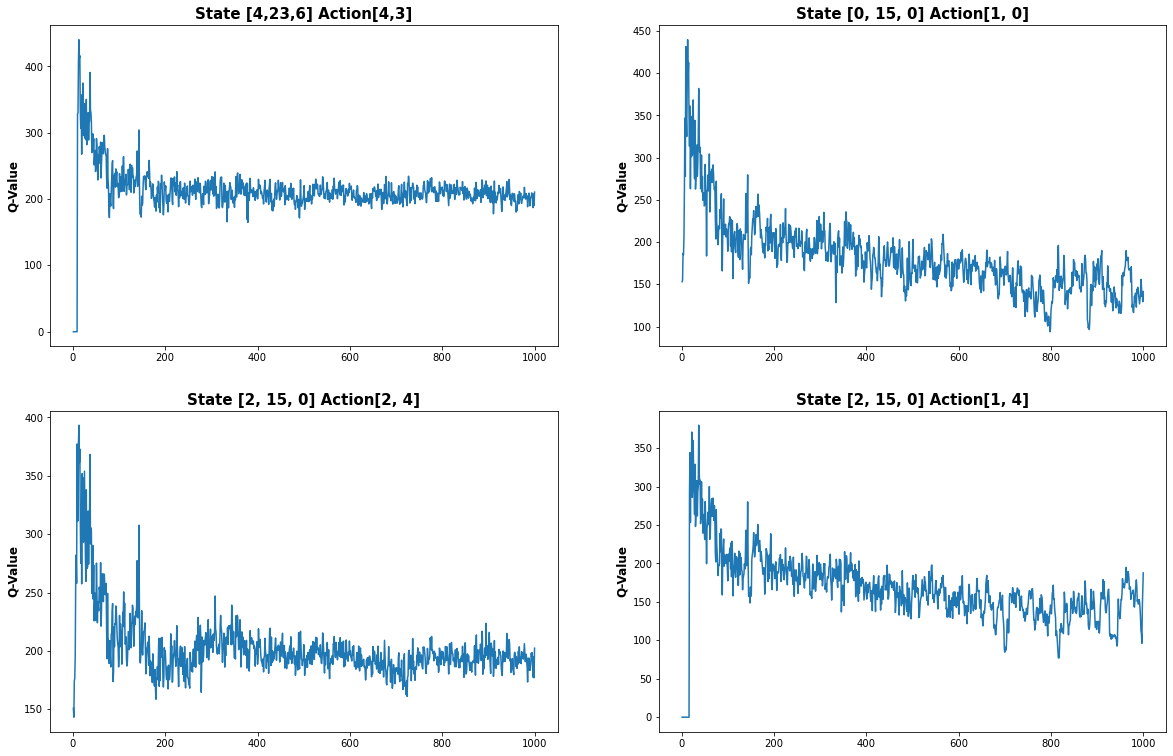

In [11]:
plt.figure(figsize=(20,13))
for i in range(4):
    plt.subplot(2,2,i+1)
    length = len(list(States_track.values())[i])
    val = States_track.get(list(States_track.keys())[i])
    plt.plot(np.arange(1,length+1),val)
    plt.ylabel("Q-Value",fontsize=12,weight='bold')
    plt.title(list(States_track.keys())[i],weight='bold',fontsize=15)
plt.show()

#### Tracking the rewards per episode

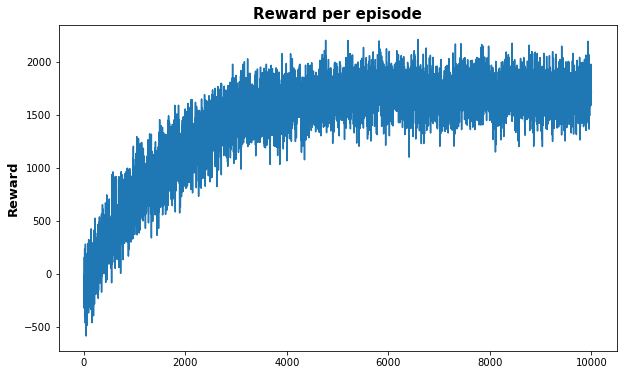

In [12]:
plt.figure(figsize=(10,6))
reward_len = len(total_episode_rewards)
plt.plot(np.arange(1,reward_len+1),total_episode_rewards)
plt.ylabel("Reward",fontsize=13,weight='bold')
plt.title("Reward per episode",weight="bold",fontsize=15)
plt.show()

#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

In [13]:
time = np.arange(0,10000)
epsilon = []
for i in range(0,10000):
    epsilon.append(np.exp(-0.0009*i))

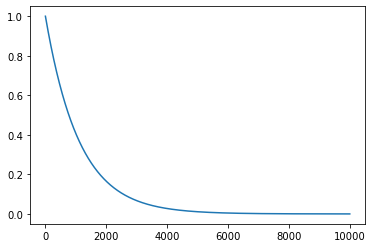

In [14]:
plt.plot(time, epsilon)
plt.show()